Pre-trained CNN network

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from torchinfo import summary
import matplotlib.pyplot as plt

In [2]:
import csv
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


Function to parse the dataset into image and label

In [4]:
def load_data(file):
  train_image = []
  train_label = []
  train_categories = {}

  with open(file) as train_data:
    data = csv.reader(train_data)
    next(data)

    for line in data:
      pixel_str = line[1]
      pixel_list = pixel_str.split()
      pixel_list = np.array(pixel_list,dtype='uint8')
      image= pixel_list.reshape((48,48))
      train_image.append(image)

      label = line[0]
      train_label.append(int(label))

      c = 1
      if label in train_categories:
        c = train_categories[label] + 1
      train_categories[label] = c

    x = np.array(train_image)
    y = np.array(train_label)
    #print(np.shape(x))
    #print(np.shape(y))
    
    return x,y


0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Text(0.5, 1.0, '0')

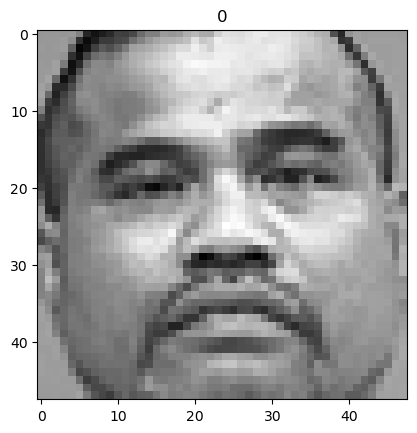

In [5]:
file = 'train.csv'
image,label = load_data(file)
i = np.random.randint(len(image))
plt.imshow(image[i], cmap = 'gray')
plt.title(label[i])

[3995, 436, 4097, 7215, 4830, 3171, 4965]


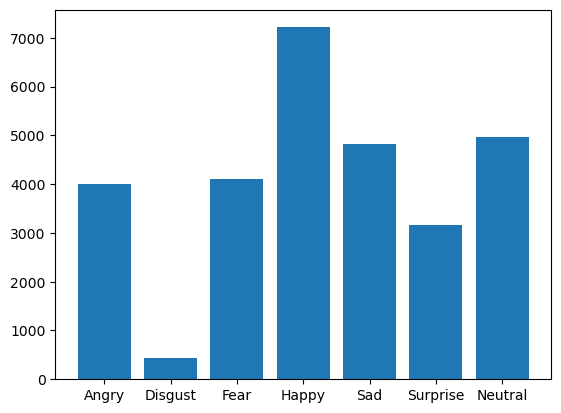

In [6]:
emotion = [0]*7
for i in label:
    if i==0:
        emotion[0] +=1
    elif i==1:
        emotion[1] +=1
    elif i==2:
        emotion[2] +=1
    elif i==3:
        emotion[3] +=1
    elif i==4:
        emotion[4] +=1
    elif i==5:
        emotion[5] +=1
    elif i==6:
        emotion[6] +=1

labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.bar(labels,height=emotion)
print(emotion)

To make a custom dataset in Pytorch using image and label and applying transformation for data augmentation in addition to convert to Tensor

In [7]:
class FERdataset(Dataset):
  def __init__(self,image,label,transform):
    self.image = image
    self.label = label
    self.transform = transform

  def __len__(self):
    return len(self.image)

  def __getitem__(self,index):
    image = self.image[index].reshape(48,48)
    image = Image.fromarray((image))
    #if self.transfrom is not None:
    image = self.transform(image)
    label = self.label[index]
    return image, label

Function to create the dataloaders

In [8]:
def dataLoaders(image,label,batch_sz_train, batch_sz_val):

  X_train,X_val,Y_train, Y_val = train_test_split(image,label,test_size=0.2,random_state=1)

  train_transform = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  val_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  
  train_data = FERdataset(X_train,Y_train,train_transform)
  val_data = FERdataset(X_val,Y_val,val_transform)

  train_loader = DataLoader(train_data, batch_size=batch_sz_train, shuffle=True)
  val_loader = DataLoader(val_data,batch_size=batch_sz_val,shuffle=True)

  
  return train_loader,val_loader


In [9]:
image,label = load_data(file)
tr,val = dataLoaders(image,label,4000,1000)
print(len(tr.dataset))

22967


Function to train the model

In [10]:
def train_network(model, train_loader, val_loader, epoch, device):
  #optimizer = optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9,0.999),
   #                      eps=1e-08, weight_decay=0.001)
  #optimizer = optim.Adam(model.parameters(),lr=learning_rate)
  optimizer = optim.Adamax(model.parameters(),lr=learning_rate)
  #scheduler = StepLR(optimizer,step_size=5,gamma=0.7)
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  for e in range(epoch):
    model.train()
    tr_loss = 0
    tr_correct = 0
    val_loss = 0
    val_correct = 0

    #training the network with train images
    for i,(image,label) in enumerate(train_loader):

      image = image.to(device)
      label = label.to(device)

      #Forward pass
      output = model(image)
      loss = F.cross_entropy(output,label)

      #Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      tr_loss += loss.item() 
      _,pred = torch.max(output,1)
      tr_correct += torch.sum(pred==label.data)
    
    #scheduler.step()

    #validating the network with validation images
    model.eval()
    with torch.no_grad():
      for i,(image,label) in enumerate(val_loader):
        image = image.to(device)
        label = label.to(device)
        output = model(image)

        lossVal = F.cross_entropy(output,label)
        val_loss += lossVal.item()
        _,pred = torch.max(output,1)
        val_correct +=torch.sum(pred==label.data)

    train_losses.append(tr_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    train_accuracy = tr_correct*100.0/len(train_loader.dataset)
    val_accuracy = val_correct*100.0/len(val_loader.dataset)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    print(f'Epoch: {e+1}/{epoch}, Training Loss: {train_losses[-1]:.3f}, Training Accuracy: {train_accuracy:.3f}% Val Loss: {val_losses[-1]:.3f}, Val Accuracy: {val_accuracy:.3f}%')

  plt.subplot(2,1,1)
  plt.plot(train_losses,'r',label='Training loss')
  plt.plot(val_losses,'g',label='validation loss')
  plt.legend(['Train loss','Validation loss'])
  #plt.xlabel('Number of epoch trained')
  plt.ylabel('Loss')
  plt.subplot(2,1,2)
  plt.plot(torch.tensor(train_accuracies).cpu().numpy(),'r',label='Training accuracy')
  plt.plot(torch.tensor(val_accuracies).cpu().numpy(),'g',label='validation accuracy')
  plt.legend(['Train accuracy','Validation accuracy'])
  plt.xlabel('Number of epoch trained')
  plt.ylabel('Accuracy')     
  plt.show()

  torch.save(model.state_dict(),'vggModel2.pth')


Loading the pre-trained VGG16 network

In [11]:
weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)
for param in model.parameters():
  param.requires_grad = False

Making the classification weights trainable for fine tuning

In [12]:
model.classifier[0] = nn.Linear(in_features=25088, out_features=4096, bias=True)
model.classifier[3] = nn.Linear(in_features=4096, out_features=4096, bias=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=7, bias=True)
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
#print(model)

In [13]:
summary(model=model, 
        input_size=(64, 1, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [64, 1, 224, 224]    [64, 7]              --                   Partial
├─Sequential (features)                  [64, 1, 224, 224]    [64, 512, 7, 7]      --                   Partial
│    └─Conv2d (0)                        [64, 1, 224, 224]    [64, 64, 224, 224]   640                  True
│    └─ReLU (1)                          [64, 64, 224, 224]   [64, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [64, 64, 224, 224]   [64, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [64, 64, 224, 224]   [64, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [64, 64, 224, 224]   [64, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [64, 64, 112, 112]   [64, 128, 112, 112]  (73,856)             False
│    └─ReLU 

Hyperparameters

In [14]:
num_epoch = 50
learning_rate = 0.0003
train_batchSize = 64
val_batchSize = 64

Epoch: 1/50, Training Loss: 1.677, Training Accuracy: 32.508% Val Loss: 1.504, Val Accuracy: 40.839%
Epoch: 2/50, Training Loss: 1.525, Training Accuracy: 40.841% Val Loss: 1.398, Val Accuracy: 46.952%
Epoch: 3/50, Training Loss: 1.446, Training Accuracy: 44.015% Val Loss: 1.344, Val Accuracy: 48.868%
Epoch: 4/50, Training Loss: 1.394, Training Accuracy: 46.732% Val Loss: 1.340, Val Accuracy: 48.293%
Epoch: 5/50, Training Loss: 1.351, Training Accuracy: 48.504% Val Loss: 1.301, Val Accuracy: 50.610%
Epoch: 6/50, Training Loss: 1.314, Training Accuracy: 50.046% Val Loss: 1.270, Val Accuracy: 51.533%
Epoch: 7/50, Training Loss: 1.279, Training Accuracy: 51.565% Val Loss: 1.247, Val Accuracy: 51.898%
Epoch: 8/50, Training Loss: 1.256, Training Accuracy: 52.528% Val Loss: 1.237, Val Accuracy: 52.543%
Epoch: 9/50, Training Loss: 1.226, Training Accuracy: 53.742% Val Loss: 1.213, Val Accuracy: 53.553%
Epoch: 10/50, Training Loss: 1.199, Training Accuracy: 54.857% Val Loss: 1.201, Val Accurac

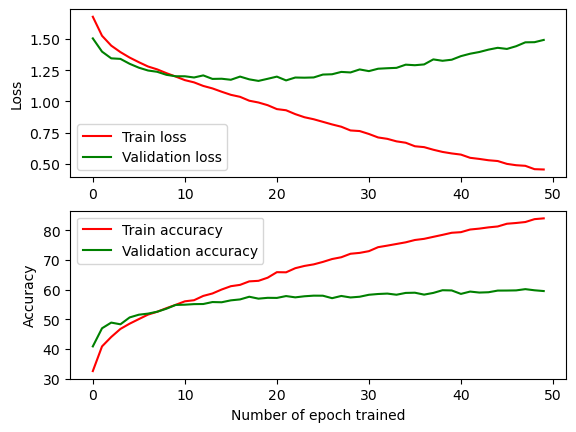

In [15]:
image,label = load_data(file)
tr_Dataloader,val_Dataloader = dataLoaders(image,label,train_batchSize,val_batchSize)
train_network(model,tr_Dataloader,val_Dataloader,epoch=num_epoch,device=device)

In [16]:
filename = 'vggModel2.pth'

Loading the fine-tuned network

In [17]:
weights = VGG16_Weights.DEFAULT
trained_network = vgg16(weights=weights)
in_feature = trained_network.classifier[6].in_features
trained_network.classifier[6] = nn.Linear(in_feature,7)
trained_network.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
for param in model.parameters():
  param.requires_grad = False
trained_network.load_state_dict(torch.load(filename))

<All keys matched successfully>

Function to test the network

In [18]:
def test_network(vgg,data_loader):
    # Test the model
    vgg.eval()

    test_loss = 0
    correct = 0
    losses = []

    trueLabel = []
    predLabel = []
    
    # Preventing gradient calculation
    with torch.no_grad():
        for image,label in data_loader:
            image = image.to(device)
            label = label.to(device)
            pred = vgg(image)
            test_loss += F.cross_entropy(pred,label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()
            trueLabel +=label.cpu().numpy().tolist()
            predLabel +=pred.argmax(1).cpu().numpy().tolist()
    test_loss /= len(data_loader)
    losses.append(test_loss)
    correct /= len(data_loader.dataset)
    accuracy = correct*100.
    print(f'Test set: Accuracy: {correct*100.:.2f}% Loss: {test_loss:.6f}')
    return trueLabel,predLabel

In [19]:
def testDataLoaders(image,label,batch_size):

  test_transform = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.507395516207, ),(0.255128989415, ))])
  
  test_data = FERdataset(image,label,test_transform)

  test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False)

  return test_loader

In [20]:
testFile = 'test.csv'
testImage,testLabel = load_data(testFile)
test_data_loader = testDataLoaders(testImage,testLabel,100)
print(len(test_data_loader.dataset))

7178


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_network.to(device)
trueLabel,predLabel = test_network(vgg=trained_network,data_loader=test_data_loader)

Test set: Accuracy: 59.64% Loss: 1.512223


Evaluating the performance of CNN

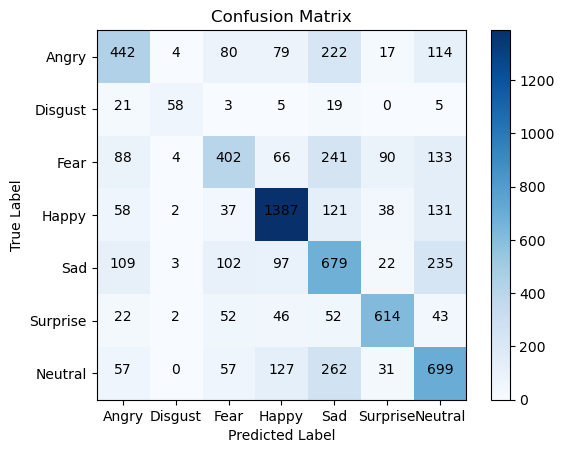

In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(trueLabel, predLabel)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
plt.xticks(range(len(labels)),labels)
plt.yticks(range(len(labels)),labels)
for i,j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment='center',color='black')
plt.show()

In [23]:
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

precision = np.round(precision,2)
recall = np.round(recall,2)
f1_score = np.round(f1_score,2)

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1_score)

Precision: [0.55 0.79 0.55 0.77 0.43 0.76 0.51]
Recall: [0.46 0.52 0.39 0.78 0.54 0.74 0.57]
F1 Score: [0.5  0.63 0.46 0.77 0.48 0.75 0.54]
